In [175]:
import networkx as nx

def readNet(fileName):
    net = {}
    f = open(fileName, "r")
    G = nx.Graph()
    for line in f:
        nodes = line.strip().split('\t')
        node1 = int(nodes[0])
        node2 = int(nodes[1])
        G.add_edge(node1, node2)
    G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)

    # return result as dictionary
    net['noNodes'] = G.number_of_nodes()
    net['noEdges'] = G.number_of_edges()
    net['adjList'] = G.adj
    return net
    #return {'num_nodes': num_nodes, 'num_edges': num_edges, 'degrees': degrees, 'adjacency_matrix': adjacency_list}

In [176]:
import networkx as nx
import numpy as np

def readFromGML(filePath):
    G = nx.read_gml(filePath, label='id')
    G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)

    adj_list = G.adj
    #print(adj_list)
    net = {}
    net['adjList'] = adj_list
    net['noNodes'] = G.number_of_nodes()
    net['noEdges'] = G.number_of_edges()

    A = nx.to_numpy_matrix(G)
    net['mat'] = A
    

    deg = dict(G.degree())
    net['degrees'] = np.array(list(deg.values()))
    
    return net

In [177]:
import matplotlib.pyplot as plt 
import warnings 

# plot a network 
def plotNetwork(network, communities, titleGML):
    np.random.seed(123) #to freeze the graph's view (networks uses a random view)
    A=np.matrix(network["mat"])
    G=nx.from_numpy_matrix(A)
    pos = nx.spring_layout(G)  # compute graph layout
    plt.figure(figsize=(8, 8))  # image is 8 x 8 inches 
    if titleGML == 'netscience.gml' or titleGML == 'cora.gml':
        nx.draw_networkx_nodes(G, pos, node_size=1, cmap=plt.cm.RdYlBu, node_color = communities)
        nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
    else:
        nx.draw_networkx_nodes(G, pos, node_size=80, cmap=plt.cm.RdYlBu, node_color = communities)
        nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(titleGML)
    plt.show(G)

### <div style="text-align:center">Used data structures throughout the program</div>

$e_{ij}$ - fraction of edges in the network that connect vertices of group $\it{i}$ to those in group $\it{j}$<br/>
$a_i = \sum_je_{ij}$<br/>
$A_{ij}$ - adjacency matrix

#### <div style="text-align: center">Modularity</div>
$$
Q = \sum_i(e_{ii}-a_i^2)
$$
<a href="https://arxiv.org/pdf/cond-mat/0309508.pdf">credit

In [178]:

def modularityFitness(e, a, V):
    #Q = sum for all communities: 
    #   (fraction of edges in) - (fraction of edges out)^2
    Q = 0
    for i in range(0, V):
        Q += e[i][i] - (a[i] ** 2)
    return Q

#### <div style="text-align:center"> Delta</div>
$$
\Delta{Q} = 2(e_{ij}-a_ia_j)
$$

In [179]:

def deltaModularityFitness(i, j, e, a, Q):
    delta = 2 * (e[i][j] - a[i] * a[j])
    return Q + delta


#### <div style="text-align: center;">Modularity density</div>
$$
L(V_i, V_j) = \sum_{i\in V_i,j\in V_j} A_{ij} 
$$
$$
L(V_i, \overline{V_j}) = \sum_{i\in {V_i},j\in {\overline{V_j}}}A_{ij}
$$
$$
d(G_i) = \frac{L(V_i, V_i) - L(V_i, \overline{V_i})}{|V_i|}, |V_i| = cardinality
$$
$$
D = \sum_{i=1}^kd(G_i),
$$
<a href="https://www.researchgate.net/publication/5334566_Quantitative_function_for_community_detection">credit

In [180]:
def modularityDensityFitness(e, E, communitySizes):
    # calculatimg the sum of densities(D(S)) for every comunity
    # D(S) = difference between noEdges in community S and noEdges outside community S
    #        divided by number of nodes in community
    #        (not always below 1?)
    D = 0
    communities = list(communitySizes.keys())
    for community in communities:
        #if we had it in the past as a community but it was adhered to another
        #idk cant remove from dictionary?;D
        if communitySizes[community] != 0:
            #multiply by E, we need the number of edges, not the fraction
            #(big number? paper assumes number of edges < cardinality of V!) 
            L1 = e[community][community]
            L2 = 0
            for otherCommunities in communities:
                if otherCommunities != community and communitySizes[otherCommunities] != 0:
                    #multiply by E again, we need the number, not the fraction
                    #maybe wrong in paper? big number
                    L2 += (e[community][otherCommunities])
            D += (L1 - L2) / communitySizes[community]
    return D

#### <div style="text-align: center;">Community Score</div>
$$
\mu_i = \frac{1}{|S|}\times\sum_{j\in S}A_{ij}, |S| = cardinality
$$
$$
M(S) = \frac{\sum_{i\in S}\left(\mu_i\right)^r}{|S|}
$$
$$
v_S = \sum_{i,j\in S}A_{ij}
$$
$$
score(S) =  M(S) \times v_S
$$
$$
CS=\sum_{i=1}^k score(S_i)
$$
<a href="https://www.researchgate.net/profile/Clara-Pizzuti/publication/221417662_A_Multi-objective_Genetic_Algorithm_for_Community_Detection_in_Networks/links/542ea6a10cf29bbc126f39d9/A-Multi-objective-Genetic-Algorithm-for-Community-Detection-in-Networks.pdf">credit

In [181]:
def communityScoreFitness(e, E, communitySizes, r):
    # calculating the sum of scores from every community
    # where the score = M(S, r) * v(S), S = a community
    # M(S) = power mean of S of order r, r - real number
    #      = fraction between number of edges inside S and S' cardinality
    #              to the power of r, divided again by the cardinality
    #       (big number? paper assumes number of edges < cardinality of S!) 
    # v(S) = volume of S = number of edges inside S 
    CS = 0
    communities = list(communitySizes.keys())
    for community in communities:
        if communitySizes[community] != 0:
            #(if?) we don't need the fraction of edges, just the number => multiply by E
            mu = (e[community][community]) / communitySizes[community]
            M = (mu ** r) / communitySizes[community]
            #dont need fraction of edges
            v = e[community][community]

            CS += (M * v)
    return CS


#### Chromosome definition
Representation - Locus-based<br/>
Initialization - One-step Markov random walk(MRW)<br/>
Crossover - Uniform crossover<br/>
Mutation - Linking marginal nodes to their optimum neighbor (marginal node = not met in the representation)<br/>
<a href="https://www.researchgate.net/publication/224205880_Genetic_Algorithm_with_Local_Search_for_Community_Mining_in_Complex_Networks">credit

In [182]:
import random
from collections import defaultdict
from enum import Enum
#import FitnessFunctions as ff
from importlib import reload
#reload(ff)
class FitnessFunction(Enum):
    modularity = 1
    modularityDensity = 2
    communityScore = 3

class Chromosome:
    def __init__(self, problParam):
        self.__problParam = problParam
        self.__V = problParam['network']['noNodes']
        self.__E = problParam['network']['noEdges']
        #fitness
        self.__fitness = 0.0
        self.__repres = []
        #for mutation, so we can choose the marginal nodes
        self.__genesNotInChromosome = []
        #degreesePercentage[i] = chance for node i to visit one of his neighbors
        #                        if he was to choose at random
        #print('calculating degreese')
        self.__degreesePercentage = self.calculateDegreese(self.__problParam['network'])
        #continue initialization with
        #one-step Markov Random Walk representation
        #print('getting initial representation')
        self.__repres, self.__genesNotInChromosome = self.getInitialRepresentation(self.__degreesePercentage, self.__problParam)
        #decoded representation, and a dictionary with keys = communityNumber, values = number of nodes in that community
       # print('decoding')
        self.__decoded, self.__communitySizes = self.decode(self.__repres)

        #we'll need to keep track of e[][], a[]
       # print('computing initial variables')
        self.__fitness, self.__e, self.__a = self.computeInitialVariables(self.__problParam['network'], self.__decoded)


    @property
    def repres(self):
        return self.__repres
    
    def decode(self, repres):
        #from locus-based representation to community representation
        #T(n)
        decoded = [-1] * (self.__V)
        commCount = 0
        communitySizes = defaultdict(int)
        for i in range(self.__V):
            if decoded[i] == -1:
                parent = repres[i]
                if decoded[parent] != -1:
                    decoded[i] = decoded[parent]
                    communitySizes[decoded[parent]] += 1
                else:
                    decoded[i] = commCount
                    communitySizes[commCount] += 1
                    while decoded[parent] == -1:
                        decoded[parent] = commCount
                        parent = repres[parent]
                        communitySizes[commCount] += 1
                    commCount += 1
        return decoded, communitySizes

    def computeInitialVariables(self, network, decoded):
        V = network['noNodes']
        E = network['noEdges']
        adjList = network['adjList']
        #e[][] matrix and a[] array
        e = [([0] * (V)) for _ in range(V)]
        a = [0] * (V)
        #building the e[][] and a[] by parsing the adjacency lists
        for node, neighbours_dict in adjList.items():
            communityNo1 = decoded[node]
            neighbours = list(neighbours_dict.keys())
            for neighbour in neighbours:
                communityNo2 = decoded[neighbour]
                e[communityNo1][communityNo2] += (1 / E)
                a[communityNo1] += (1 / E)
        #computing our initial fitness value
        if self.__problParam['fitness'] == FitnessFunction.modularity:
            fitness = modularityFitness(e, a, V)
        if self.__problParam['fitness'] == FitnessFunction.modularityDensity:
            fitness = modularityDensityFitness(e, E, self.__communitySizes)
        if self.__problParam['fitness'] == FitnessFunction.communityScore:
            fitness = communityScoreFitness(e, E, self.__communitySizes, self.__problParam['r'])

        return fitness, e, a
        
    def getInitialRepresentation(self, degreesePercentage, problParam):
        network = problParam['network']
        adjList = network['adjList']
        V = network['noNodes']

        genesNotInChromosome = [i for i in range(V)]
        repres = [0] * (V)
        #for each vertex
        for i in range(V):
            #will check all probability intervals to see which neighbor we will choose 
            #generate random nr from (0, 1)
            p = random.random()
            leftComparison = 0
            rightComparison = degreesePercentage[i]
            #we assume we want the first neighbor
            neighbor = 0
            #making sure we stop at the last interval of probability
            if degreesePercentage[i] != 0:
                gene = random.choice(list(adjList[i].keys()))
                if gene in genesNotInChromosome:
                    genesNotInChromosome.remove(gene)
                repres[i] = gene
            else:
                repres[i] = i
        return repres, genesNotInChromosome

    def calculateDegreese(self, network):
        adjList = network['adjList']
        V = network['noNodes']
        degreesePercentage = [0] * (V)
        #print(V)
        for i in range(V):
            #print(i, adjList[i])
            if(len(adjList[i]) != 0):
                degreesePercentage[i] = 1 / len(adjList[i])
            else:
                degreesePercentage[i] = 0
        return degreesePercentage
    @property
    def repres(self):
        return self.__repres

    @property
    def fitness(self):
        return self.__fitness
    
    @repres.setter
    def repres(self, l = []):
        self.__repres = l
    
    @fitness.setter
    def fitness(self, fit = 0.0):
        self.__fitness = fit

    def crossover(self, c):
        length = len(self.__repres)
        #binary array 
        #1 => from first parent
        #0 => from second parent
        choiceArray = [random.randint(0, 1) for _ in range(length)]
        newrepres = []
        for i in range(length):
            if choiceArray[i] == 1:
                newrepres.append(self.__repres[i])
            else:
                newrepres.append(c.__repres[i])
        offspring = Chromosome(self.__problParam)
        offspring.repres = newrepres
        return offspring
    
    def mutation(self):
        network = self.__problParam['network']
        adjList = network['adjList']
        max_global_f_in = -100
        #iterating over the marginal nodes
        for i in self.__genesNotInChromosome:
            max_local_f_in = -100
            max_neighbor = -100
            #if it's a marginal node (not currently in the chromosome)
            #iterating over its neighbors
            communityNoI = self.__decoded[i]
            for neighbor in adjList[i].keys():
                #calculating fitness function by uniting
                #node i with neighbor node
                communityNoNeighbor = self.__decoded[neighbor]
                if self.__problParam['fitness'] == FitnessFunction.modularity:
                    f_in = deltaModularityFitness(communityNoI, communityNoNeighbor, self.__e, self.__a, self.__fitness)
                if self.__problParam['fitness'] == FitnessFunction.modularityDensity:
                    #calculate e as if we associate the 2 nodes in same community
                    new_e, _ = self.recalculateVariables(network['noNodes'], communityNoI, communityNoNeighbor, self.__e.copy(), self.__a.copy(), self.__E, self.__problParam['network']['adjList'], self.__decoded)
                    f_in = modularityDensityFitness(new_e, self.__E, self.__communitySizes)
                if self.__problParam['fitness'] == FitnessFunction.communityScore:
                    #calculate e as if we associate the 2 nodes in same community
                    new_e, _ = self.recalculateVariables(network['noNodes'], communityNoI, communityNoNeighbor, self.__e.copy(), self.__a.copy(), self.__E, self.__problParam['network']['adjList'], self.__decoded)
                    f_in = communityScoreFitness(new_e, self.__E, self.__communitySizes, self.__problParam['r'])
                #improvement => updating our max data
                if f_in > max_local_f_in:
                    if f_in > max_global_f_in:
                        max_global_f_in = f_in
                    max_local_f_in = f_in
                    max_neighbor = neighbor
            #updating repres, genesNotInChromosome
            #e[][] and a[] for modularity
            self.__repres[max_neighbor] = i  
            self.__genesNotInChromosome.remove(i)
            self.__e, self.__a = self.recalculateVariables(network['noNodes'], self.__decoded[i], self.__decoded[max_neighbor], self.__e, self.__a, self.__E, self.__problParam['network']['adjList'], self.__decoded)
            self.__communitySizes = self.recalculateCommunitySizes(self.__decoded, max_neighbor, i, self.__communitySizes)
        self.__decoded = self.decode(self.__repres)
        self.__fitness = max_global_f_in
        return self.__repres
        
    def recalculateCommunitySizes(self, decoded, max_neighbor, i, communitySizes):
        #max_neighbor -> i
        #=> comm of max_neighbor adds community of i
        communityMaxNeighbor = decoded[max_neighbor]
        communityI = decoded[i]
        communitySizes[communityMaxNeighbor] += communitySizes[communityI]
        communitySizes[communityI] = 0
        return communitySizes

    #i = community of i
    #max_neighbor = community of max_neighbor
    #recalculating e[][]
    #max_neighbor -> i (type connection)
    #=> comm of i will now adhere to comm of max_neighbor
    def recalculateVariables(self, V, communityI, communityMax, e, a, E, adjList, decoded):
        for v in range(V):
            if v == communityI:
                e[communityMax][v] = 0
                e[v][communityMax] = 0
            else:
                e[communityMax][v] += e[communityI][v]
                e[v][communityMax] += e[v][communityI]
                if v == communityMax:
                    e[v][v] -= e[v][communityI]
            e[communityI][v] = 0
            e[v][communityI] = 0
        #updating the a[] array
        edgesToNewNode = 0
        for node, neighbours_dict in adjList.items():
            if decoded[node] == communityMax:
                neighbours = list(neighbours_dict.keys())
                for neighbour in neighbours:
                    if decoded[neighbour] == communityI:
                        edgesToNewNode += 1
        a[communityMax] += a[communityI] - (edgesToNewNode / E)
        a[communityI] = 0
        return e, a

    def __str__(self):
        return '\nChromosome: ' + str(self.__repres) + ' has fit: '+ str(self.__fitness)
    
    def __repr__(self):
        return self.__str__()
    
    def __eq__(self, c):
        return self.__repres == c.__repres and self.__fitness == c.__fitness

#### Genetic algorithm
Each generation: $\mu$ parents, $\lambda$ offspring<br/>
Proceed further with $\mu$ best individuals

In [183]:
from random import randint
class GA:
    def __init__(self, param = None, problParam = None):
        self.__param = param
        self.__problParam = problParam
        self.__population = []

    @property
    def population(self):
        return self.__population
    
    def initialisation(self):
        for chrCount in range(self.__param['popSize']):
            #print('chr:', chrCount)
            c = Chromosome(self.__problParam)
            self.__population.append(c)

    def evaluation(self):
        pass

    def bestChromosome(self):
        best = self.__population[0]
        for c in self.__population:
            if c.fitness > best.fitness:
                best = c
        return best

    def selection(self):
        pos1 = randint(0, self.__param['popSize'] - 1)
        pos2 = randint(0, self.__param['popSize'] - 1)
        if (self.__population[pos1].fitness < self.__population[pos2].fitness):
            return pos1
        else:
            return pos2 

    def nextGeneration(self):
        #using miu + lambda (generating lambda offspring, keeping miu individuals, based on fitness)
        for offspringNo in range(self.__param['offspringSize']):
            #print('offspring number:', offspringNo)
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            offspring = p1.crossover(p2)
            offspring.mutation()
            self.__population.append(offspring)
        #sorting ascending by fitness
        self.__population.sort(key=lambda x: x.fitness, reverse=True)
        #selecting the last 'popSize' amount
        self.__population = self.__population[:self.__param['popSize']]
    
        





Label(value='')

IntProgress(value=0, max=9)

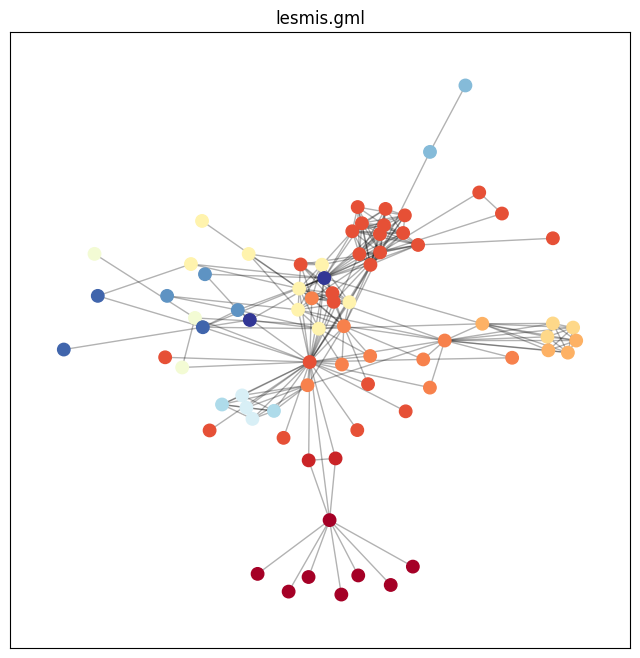

Label(value='')

IntProgress(value=0, max=9)

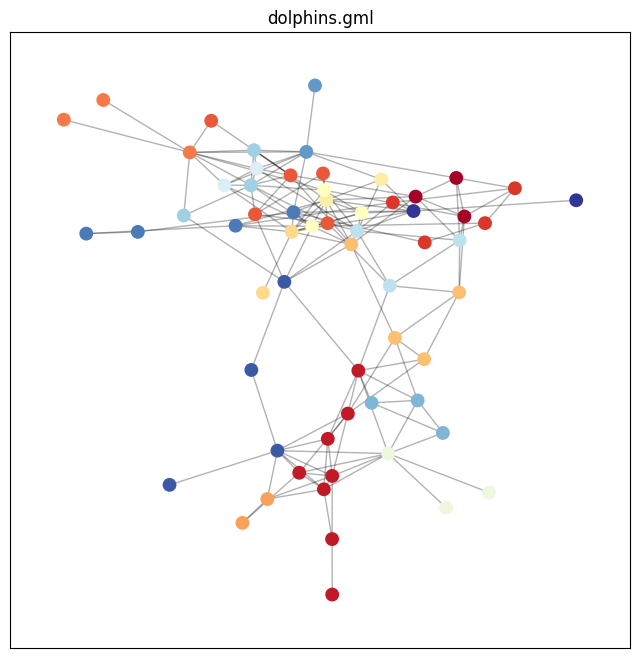

Label(value='')

IntProgress(value=0, max=9)

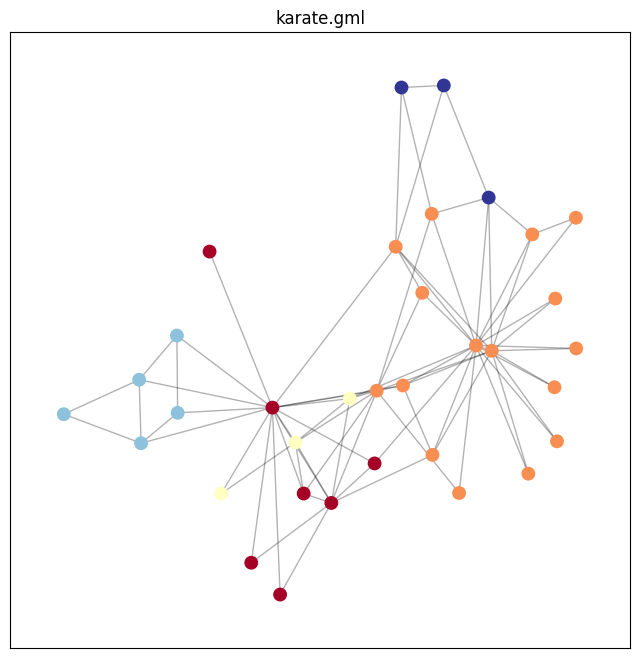

Label(value='')

IntProgress(value=0, max=9)

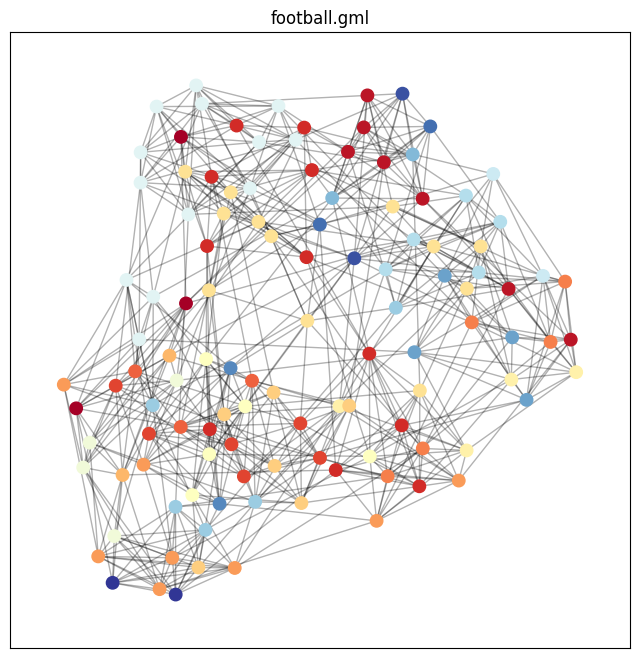

Label(value='')

IntProgress(value=0, max=9)

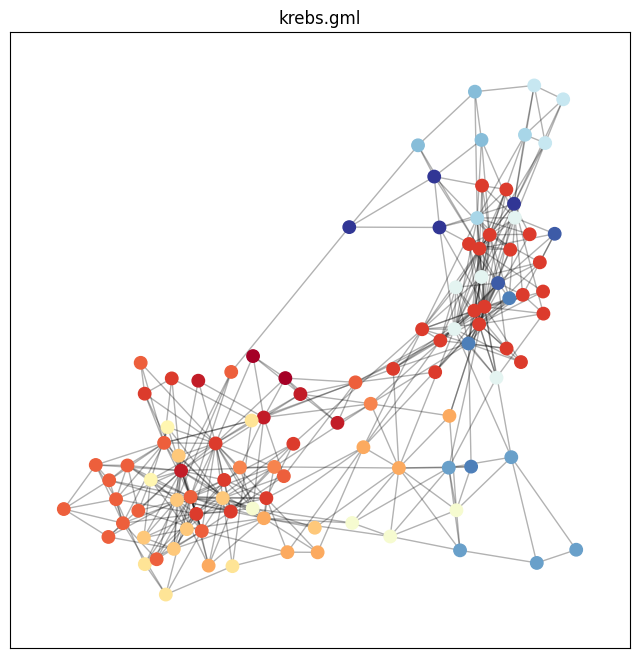

Label(value='')

IntProgress(value=0, max=9)

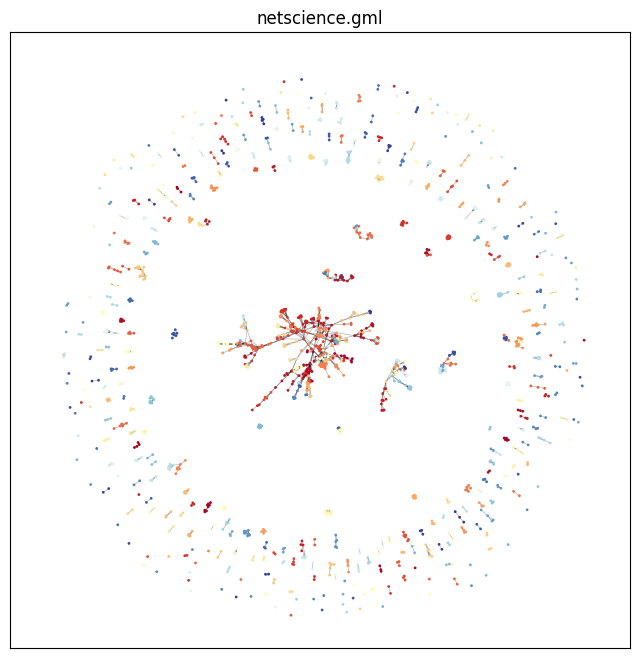

Label(value='')

IntProgress(value=0, max=9)

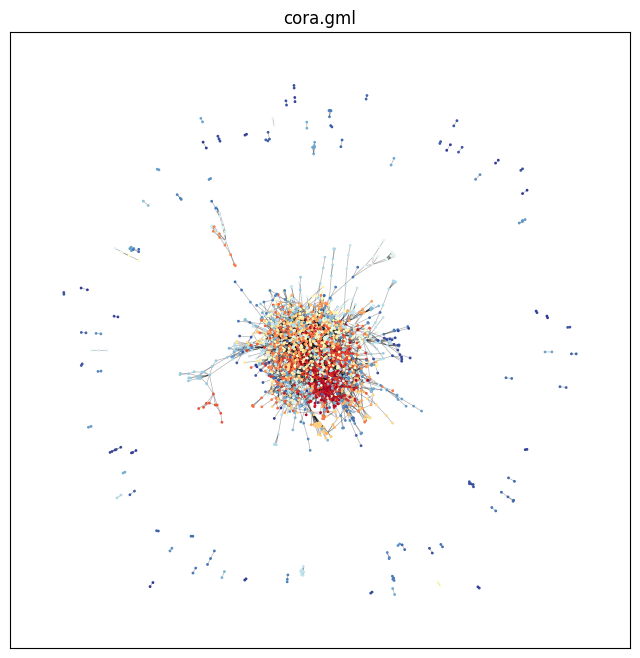

In [184]:
import ipywidgets as widgets
from IPython.display import display
import time
from random import seed

seed(1)

def plotForNetwork(network, title, fitness):
    gaParam = {'popSize' : 10, 'noGen' : 10, 'offspringSize' : 70, 'network' : network}
    #print(network['adjList'])
    problParam = {'fitness' :  fitness, 'network' : network, 'r':3}

    label = widgets.Label()
    display(label)


    progressBar = widgets.IntProgress(min = 0, max = gaParam['noGen'] - 1)
    display(progressBar)
    
    ga = GA(gaParam, problParam)
    #print(gaParam)
    ga.initialisation()
    ga.evaluation()

    bestChromo = None

    for g in range(gaParam['noGen']):
        ga.nextGeneration()
        bestChromo = ga.bestChromosome()
        label.value = 'Using ' + str(problParam['fitness']) + ': Best fitness = ' + str(bestChromo.fitness)
        progressBar.value += 1
        time.sleep(0.01)
    plotNetwork(network, bestChromo.decode(bestChromo.repres)[0] , title)



#no memory lol;D
#network = readNet('data\\real\\com-dblp.ungraph.txt')
#print('finished reading graph')
#plotForNetwork(network, 'com-dblp.ungraph.txt', FitnessFunction.modularity)

network = readFromGML('data\\real\\lesmis.gml')
plotForNetwork(network, 'lesmis.gml', FitnessFunction.modularity)
# network = readFromGML('data\\real\\lesmis.gml')
# plotForNetwork(network, 'lesmis.gml', FitnessFunction.modularityDensity)
# # network = readFromGML('data\\real\\lesmis.gml')
# # plotForNetwork(network, 'lesmis.gml', FitnessFunction.communityScore)

# # network = readFromGML('data\\real\\dolphins\\dolphins.gml', )
# # plotForNetwork(network, 'dolphins.gml', FitnessFunction.modularity)
network = readFromGML('data\\real\\dolphins\\dolphins.gml', )
plotForNetwork(network, 'dolphins.gml', FitnessFunction.modularityDensity)
# network = readFromGML('data\\real\\dolphins\\dolphins.gml', )
# plotForNetwork(network, 'dolphins.gml', FitnessFunction.communityScore)

# network = readFromGML('data\\real\\karate\\karate.gml')
# plotForNetwork(network, 'karate.gml', FitnessFunction.modularity)
# # network = readFromGML('data\\real\\karate\\karate.gml')
# # plotForNetwork(network, 'karate.gml', FitnessFunction.modularityDensity)
network = readFromGML('data\\real\\karate\\karate.gml')
plotForNetwork(network, 'karate.gml', FitnessFunction.communityScore)

# network = readFromGML('data\\real\\football\\football.gml')
# plotForNetwork(network, 'football.gml', FitnessFunction.modularity)
network = readFromGML('data\\real\\football\\football.gml')
plotForNetwork(network, 'football.gml', FitnessFunction.modularityDensity)
# network = readFromGML('data\\real\\football\\football.gml')
# plotForNetwork(network, 'football.gml', FitnessFunction.communityScore)

network = readFromGML('data\\real\\krebs\\krebs.gml')
plotForNetwork(network, 'krebs.gml', FitnessFunction.modularity)
# # network = readFromGML('data\\real\\krebs\\krebs.gml')
# # plotForNetwork(network, 'krebs.gml', FitnessFunction.modularityDensity)
# # network = readFromGML('data\\real\\krebs\\krebs.gml')
# plotForNetwork(network, 'krebs.gml', FitnessFunction.communityScore)

network = readFromGML('data\\real\\netscience.gml')
plotForNetwork(network, 'netscience.gml', FitnessFunction.modularity)

network = readFromGML('data\\real\\cora.gml')
plotForNetwork(network, 'cora.gml', FitnessFunction.modularity)
